In [5]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

from keras.applications.densenet import DenseNet121, preprocess_input

In [4]:
breed_list = os.listdir(r'/Users/test/Desktop/Cours/deep_learning/rendu_propre/Movie_Poster_Dataset')

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir(r'/Users/test/Desktop/Cours/deep_learning/rendu_propre/Movie_Poster_Dataset/{}'.format(breed)))
print("{} images".format(n_total_images))

38 breeds


NotADirectoryError: [Errno 20] Not a directory: '/Users/test/Desktop/Cours/deep_learning/rendu_propre/Movie_Poster_Dataset/projet-movie.ipynb'

In [14]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [17]:
   def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = r'C:\Users\Maïmouna COULIBALY\Desktop\M2 Data ingeener & data science\projet-final\Movie_Poster_Dataset/{}/'.format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

1985


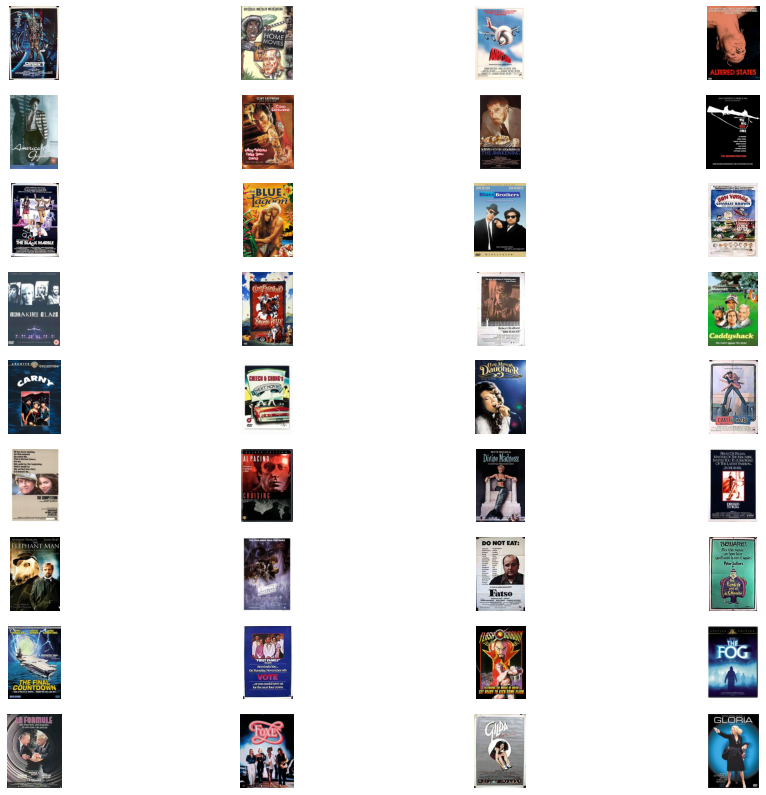

In [25]:
print(breed_list[5])
show_dir_images(breed_list[0], 36)

In [78]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

#os.mkdir('data')
#for breed in breed_list:
  #  os.mkdir('data/' + breed)
#print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir(r'C:\Users\Maïmouna COULIBALY\Desktop\M2 Data ingeener & data science\projet-final\Movie_Poster_Dataset\{}'.format(breed)):
        img = Image.open(r'C:\Users\Maïmouna COULIBALY\Desktop\M2 Data ingeener & data science\projet-final\Movie_Poster_Dataset\{}\{}'.format(breed, file))
        tree = ET.parse(r'C:\Users\Maïmouna COULIBALY\Desktop\M2 Data ingeener & data science\projet-final\Movie_Poster_Dataset\{}\{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')


ParseError: not well-formed (invalid token): line 1, column 0 (<string>)

In [124]:
data_dir = r'C:\Users\Maïmouna COULIBALY\Desktop\M2 Data ingeener & data science\projet-final\data'

In [125]:

checkpoint = ModelCheckpoint( data_dir+nom_checkpoint_model+'.h5', monitor='val_loss', verbose=1,save_best_only=True, mode='auto', save_weights_only=False, period=1 ) 
earlystop = EarlyStopping( monitor='val_loss',min_delta=0.001, patience=3, verbose=1, mode='auto' ) 
csvlogger = CSVLogger( filename= data_dir+"training_csv.log",separator = ",", append = False ) 
reduceLR = ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=3,verbose=1, mode='auto' )
# On enregistre dans un tableau callbacks, qu'on va fournir lors de l'entrainement du modèle
callbacks = [checkpoint, earlystop, csvlogger,reduceLR]


NameError: name 'nom_checkpoint_model' is not defined

In [79]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Movie_Poster_Dataset',
 'projet-movie.ipynb',
 'test',
 'train',
 'valid']

In [50]:
pip install np_utils

  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57125 sha256=a4eb1668691c713af332f237c42157d9e43b9387612edafc748d06e6feb3411c
  Stored in directory: c:\users\maïmouna coulibaly\appdata\local\pip\cache\wheels\57\18\82\402fcaf521e84dfa67b077aea34d225fc32ce6085e2cb8dda6
Note: you may need to restart the kernel to use updated packages.
Successfully built np-utils


In [71]:
import np_utils

In [72]:
from keras.utils import np_utils

In [80]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

In [81]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

In [83]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths,targets,test_size=0.15,random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

In [93]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights=(r'C:\Users\Maïmouna COULIBALY\Desktop\M2 Data ingeener & data science\projet-final\train',
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

SyntaxError: invalid syntax (<ipython-input-93-12924a1f40b6>, line 4)

In [97]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

In [104]:
# Ds le cadre du df data2 : x1, x2 comme features
inputs = tf.keras.layers.Input(shape=(2, ))

In [105]:
# Maintenant, ns travaillons sur des images, ns indiquons 
# les dim de l'image => (heigth, width, mode)
# del model
 
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
 
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)
 
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
 
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)
 
x = tf.keras.layers.Flatten()(x)
 
x = tf.keras.layers.Dense(512, activation='relu')(x)
 
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
 
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)       

In [106]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [114]:
model.compile(loss="binary_crossentropy", metrics=["acc"],
             optimizer='rmsprop')

In [117]:
history = model.fit(
    train_gen,
    steps_per_epoch=80,  
    epochs=3,
    verbose=1,
    validation_data=val_gen,
    validation_steps=50
)

ValueError: could not broadcast input array from shape (447,300,3) into shape (224,224,3)

In [115]:
history = model.fit(train_gen, epochs = 3, steps_per_epoch=100, 
          validation_data=val_gen, validation_steps=50)

ValueError: could not broadcast input array from shape (447,300,3) into shape (224,224,3)

In [107]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [110]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=3)

ValueError: could not broadcast input array from shape (447,300,3) into shape (224,224,3)